#PREPARACIÓN NOTEBOOK
---

##Librerías

In [1]:
from google.colab import drive
import sys
import os
import shutil
import sqlite3 as sql #Crear y trabajar bases de datos ligeras
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder

##Conexión con la BD y el repositorio en Drive

In [2]:
#Conectar al drive local
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Conectar al repositorio
path = '/content/drive/My Drive/cod/A3_marketing'

sys.path.append(path) #Importar las funciones propias a través de import, porque incluye la carpeta del repositorio como uno de esos paquetes para que import busque funciones
os.chdir(path) #Subir y descargar archivos de la ruta del repositorio de trabajo

In [4]:
# Definir rutas (ASEGÚRATE DE USAR LA EXTENSIÓN CORRECTA)
DATABASE_ORIGINAL_PATH = '/content/drive/My Drive/cod/A3_marketing/data/db_movies'
DATABASE_COPY_PATH = '/content/drive/My Drive/cod/A3_marketing/data/db_movies_c'

#Crear una copia de la base de datos original
try:
    shutil.copy2(DATABASE_ORIGINAL_PATH, DATABASE_COPY_PATH)
    print(f"Se ha creado una copia de la base de datos en: {DATABASE_COPY_PATH}")
except FileNotFoundError:
    print(f"Error: No se encontró la base de datos original en: {DATABASE_ORIGINAL_PATH}")
    exit()
except Exception as e:
    print(f"Error al copiar la base de datos: {e}")
    exit()

Se ha creado una copia de la base de datos en: /content/drive/My Drive/cod/A3_marketing/data/db_movies_c


##Conexión al notebook de funciones

In [5]:
%run a_funciones.ipynb

##Conexión a la base

In [6]:
#Conexión a la COPIA de la Base de Datos
def conectar_bd(path):
    """Establece una conexión con la base de datos SQLite."""
    try:
        con = sql.connect(path)
        cursor = con.cursor()
        print(f"Conexión exitosa a la base de datos (copia): {path}")
        return con, cursor
    except sql.Error as e:
        print(f"Error al conectar a la base de datos (copia) {path}: {e}")
        return None, None

con, cur = conectar_bd(DATABASE_COPY_PATH)

Conexión exitosa a la base de datos (copia): /content/drive/My Drive/cod/A3_marketing/data/db_movies_c


In [7]:
con = sql.connect('data/db_movies_c') #Conectarse a la base de datos existente y transportar datos
cur = con.cursor() #Otra conexión (cursor) para ejecutar las consultas en la bd sin traer ni llevar info

In [8]:
#Consultar qué tablas disponibles tiene la bd
cur.execute(""" select name from sqlite_master where type= 'table' """)
cur.fetchall()

[('ratings',), ('movies',)]

#Exploración con SQL
---

##Exploración inicial

In [9]:
if cur:
    tablas = listar_tablas(cur)
    tablas_a_explorar_sql = ['ratings', 'movies']
    for tabla in tablas_a_explorar_sql:
        if tabla in tablas:
            explorar_esquema_tabla(cur, tabla)
            contar_filas_tabla(cur, tabla)
            mostrar_primeras_filas_sql(cur, tabla)


Tablas encontradas en la base de datos:
- ratings
- movies

--- Esquema de la tabla 'ratings' ---
  - Nombre: userId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: movieId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: rating, Tipo: REAL, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: timestamp, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0

Número total de filas en 'ratings': 100836

--- Primeras 5 filas de la tabla 'ratings' ---
(1, 1, 4.0, 964982703)
(1, 3, 4.0, 964981247)
(1, 6, 4.0, 964982224)
(1, 47, 5.0, 964983815)
(1, 50, 5.0, 964982931)

--- Esquema de la tabla 'movies' ---
  - Nombre: movieId, Tipo: INTEGER, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: title, Tipo: TEXT, ¿Nulo?: 0, Clave Primaria: 0
  - Nombre: genres, Tipo: TEXT, ¿Nulo?: 0, Clave Primaria: 0

Número total de filas en 'movies': 9742

--- Primeras 5 filas de la tabla 'movies' ---
(1, 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy')
(2, 'Jumanji (1995)', 'Adventure|Children|Fantasy')


##Exploración específica para el sistema de recoemndación

In [10]:
conteo_usuarios_peliculas(cur)
distribucion_calificaciones(cur)
# Cargar las calificaciones en un DataFrame para calcular la moda
df_ratings_temp = pd.read_sql('SELECT rating FROM ratings', con)
moda_calificaciones_inicial = calcular_moda(df_ratings_temp['rating'].tolist())
print(f"\n--- Moda de las calificaciones ---")
print(moda_calificaciones_inicial)
top_n_peliculas_valoradas(cur, n=10)

Número total de usuarios únicos: 610
Número total de películas únicas: 9724

--- Moda de las calificaciones ---
4.0


,title,total_valoraciones,movieId
0,Forrest Gump (1994),329,356
1,"Shawshank Redemption, The (1994)",317,318
2,Pulp Fiction (1994),307,296
3,"Silence of the Lambs, The (1991)",279,593
4,"Matrix, The (1999)",278,2571
5,Star Wars: Episode IV - A New Hope (1977),251,260
6,Jurassic Park (1993),238,480
7,Braveheart (1995),237,110
8,Terminator 2: Judgment Day (1991),224,589
9,Schindler's List (1993),220,527


#Preprocesamiento con SQL
---

##Extracción del año y limpieza de títulos

In [11]:
cur.execute("""
ALTER TABLE movies ADD COLUMN year INTEGER;
""")
con.commit()
print("\nSe añadió la columna 'year' a la tabla 'movies'.")

cur.execute("""
UPDATE movies
SET year = CAST(SUBSTR(TRIM(SUBSTR(title, INSTR(title, '(') + 1, 4)), 1, 4) AS INTEGER)
WHERE INSTR(title, '(') > 0 AND SUBSTR(TRIM(SUBSTR(title, INSTR(title, '(') + 1, 4)), 1, 4) GLOB '[1-2][0-9][0-9][0-9]';
""")
con.commit()
print("\nSe extrajo el año de los títulos y se actualizó la columna 'year'.")

cur.execute("""
UPDATE movies
SET title = TRIM(SUBSTR(title, 1, IIF(INSTR(title, '(') > 0, INSTR(title, '(') - 1, LENGTH(title))));
""")
con.commit()
print("\nSe eliminaron los años de los títulos'.")

# Mostrar las primeras filas para ver el resultado
cur.execute("SELECT movieId, title, year FROM movies LIMIT 5;")
primeras_filas_post_extraccion = cur.fetchall()
if primeras_filas_post_extraccion:
    print("\nPrimeras filas de la tabla 'movies':")
    for fila in primeras_filas_post_extraccion:
        print(fila)
else:
    print("\nLa tabla está vacía")


Se añadió la columna 'year' a la tabla 'movies'.

Se extrajo el año de los títulos y se actualizó la columna 'year'.

Se eliminaron los años de los títulos'.

Primeras filas de la tabla 'movies':
(1, 'Toy Story', 1995)
(2, 'Jumanji', 1995)
(3, 'Grumpier Old Men', 1995)
(4, 'Waiting to Exhale', 1995)
(5, 'Father of the Bride Part II', 1995)


##Exploración de datos sin año y sin género

In [12]:
# Cargar la tabla movies en un DataFrame para facilitar el análisis
df_movies_antes_eliminar = pd.read_sql('SELECT movieId, title, genres FROM movies', con)

# Buscar películas sin un año válido
peliculas_sin_anio_antes = df_movies_antes_eliminar[df_movies_antes_eliminar['title'].str.contains(r'\((\d{4})\)') == False]
print(f"\nNúmero de películas que parecen no tener un año válido: {len(peliculas_sin_anio_antes)}")
if not peliculas_sin_anio_antes.empty:
    print("Primeras películas sin año aparente:")
    print(peliculas_sin_anio_antes.head())

# Buscar películas sin género
peliculas_sin_genero_antes = df_movies_antes_eliminar[df_movies_antes_eliminar['genres'] == '(no genres listed)']
print(f"\nNúmero de películas sin género: {len(peliculas_sin_genero_antes)}")
if not peliculas_sin_genero_antes.empty:
    print("Primeras películas sin género:")
    print(peliculas_sin_genero_antes.head())


Número de películas que parecen no tener un año válido: 9742
Primeras películas sin año aparente:
   movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Número de películas sin género: 34
Primeras películas sin género:
      movieId                                             title  \
8517   114335                                        La cravate   
8684   122888                                           Ben-hur   
8687   122896  Pirates of the Caribbean: Dead Men Tell No Tales   
8782   129250

<ipython-input-12-79c60bd90c24>:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  peliculas_sin_anio_antes = df_movies_antes_eliminar[df_movies_antes_eliminar['title'].str.contains(r'\((\d{4})\)') == False]


##Eliminación de películas sin año

In [13]:
cur.execute("""
SELECT movieId, title FROM movies WHERE year IS NULL;
""")
peliculas_sin_anio_post_extraccion = pd.DataFrame(cur.fetchall(), columns=['movieId', 'title'])
print(f"\nNúmero de películas sin año después de la extracción: {len(peliculas_sin_anio_post_extraccion)}")
if not peliculas_sin_anio_post_extraccion.empty:
    print("Primeras películas sin año:")
    print(peliculas_sin_anio_post_extraccion.head())

cur.execute("""
DELETE FROM movies WHERE year IS NULL;
""")
con.commit()
print("\nPelículas sin año eliminadas de la tabla 'movies'.")


Número de películas sin año después de la extracción: 1085
Primeras películas sin año:
   movieId                       title
0       29  City of Lost Children, The
1       30              Shanghai Triad
2       32              Twelve Monkeys
3       47                       Seven
4       58                Postman, The

Películas sin año eliminadas de la tabla 'movies'.


##Eliminación de películas sin género

In [14]:
cur.execute("""
SELECT movieId, title, genres FROM movies WHERE genres = '(no genres listed)';
""")
peliculas_sin_genero_antes_eliminar = pd.DataFrame(cur.fetchall(), columns=['movieId', 'title', 'genres'])
print(f"\nNúmero de películas sin género listado (antes de la eliminación): {len(peliculas_sin_genero_antes_eliminar)}")
if not peliculas_sin_genero_antes_eliminar.empty:
    print("Primeras películas sin género listado (antes de la eliminación):")
    print(peliculas_sin_genero_antes_eliminar.head())

cur.execute("""
DELETE FROM movies WHERE genres = '(no genres listed)';
""")
con.commit()
print("\nPelículas sin género listado eliminadas de la tabla 'movies' (copia).")


Número de películas sin género listado (antes de la eliminación): 26
Primeras películas sin género listado (antes de la eliminación):
   movieId                                             title  \
0   114335                                        La cravate   
1   122888                                           Ben-hur   
2   122896  Pirates of the Caribbean: Dead Men Tell No Tales   
3   129250                                        Superfast!   
4   132084                                      Let It Be Me   

               genres  
0  (no genres listed)  
1  (no genres listed)  
2  (no genres listed)  
3  (no genres listed)  
4  (no genres listed)  

Películas sin género listado eliminadas de la tabla 'movies' (copia).


##Cargar datos limpios en Pandas y separar géneros

In [15]:
df_ratings_processed = pd.read_sql('SELECT userId, movieId, rating FROM ratings', con)
df_movies_processed = pd.read_sql('SELECT movieId, title, year, genres FROM movies', con)

print("\nPrimeras filas de df_movies_processed (antes de separar géneros):\n", df_movies_processed.head())

# Separar los géneros usando la función importada
df_movies_processed = separar_generos(df_movies_processed.copy())

print("\nPrimeras filas de df_movies_processed (con géneros separados):\n", df_movies_processed.head())

print("\nPrimeras filas de df_ratings_processed (limpio):\n", df_ratings_processed.head())


Primeras filas de df_movies_processed (antes de separar géneros):
    movieId                        title  year  \
0        1                    Toy Story  1995   
1        2                      Jumanji  1995   
2        3             Grumpier Old Men  1995   
3        4            Waiting to Exhale  1995   
4        5  Father of the Bride Part II  1995   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Primeras filas de df_movies_processed (con géneros separados):
    movieId                        title  year  Action  Adventure  Animation  \
0        1                    Toy Story  1995       0          1          1   
1        2                      Jumanji  1995       0          1          0   
2        3             Grumpier Old Men  

#Análisis exploratoria (EDA)
---

##Distribución de clafisifaciones

In [16]:
df_rating_dist = distribucion_calificaciones(cur)
print(df_rating_dist)
fig = px.bar(df_rating_dist, x='rating', y='frecuencia',
                             title='Distribución de Calificaciones',
                             labels={'rating': 'Calificación', 'frecuencia': 'Frecuencia'})

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig.show()

   rating  frecuencia
0     0.5        1370
1     1.0        2811
2     1.5        1791
3     2.0        7551
4     2.5        5550
5     3.0       20047
6     3.5       13136
7     4.0       26818
8     4.5        8551
9     5.0       13211


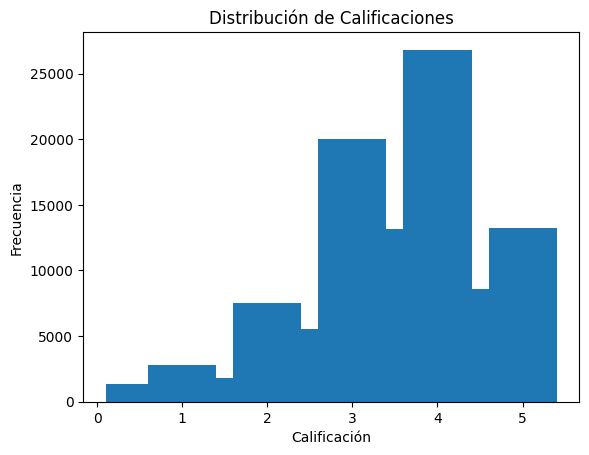

In [17]:
figg = plt.bar(df_rating_dist['rating'], df_rating_dist['frecuencia'])
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.title('Distribución de Calificaciones')
plt.show()

El histograma muestra que la mayoria de las calificaciones se concentran entre 3.0 y 4.0 con un pico en la calificaicón 4.0, lo cual indica una tendencia positiva en la percepcion de las peliculas por parte de los usuarios. Las calificaciones bajas, entre 0 a 2.5, son menos frecuentes, lo que nos podria decir que los usuarios tienden a valorar mas positivamente las peliculas.

##Distribución de calificaciones por usuario

In [18]:
cur.execute("""
    SELECT userId, COUNT(*) as cnt_rating
    FROM ratings
    GROUP BY userId
""")
user_ratings = pd.DataFrame(cur.fetchall(), columns=['userId', 'cnt_rating'])

fig2 = px.histogram(user_ratings,
                   x='cnt_rating',
                   nbins=30,
                   title='Numero de calificaciones por usuario',
                   labels={'cnt_rating': 'Cantidad de calificaciones', 'count': 'Frecuencia de usuarios'})

fig2.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig2.show()

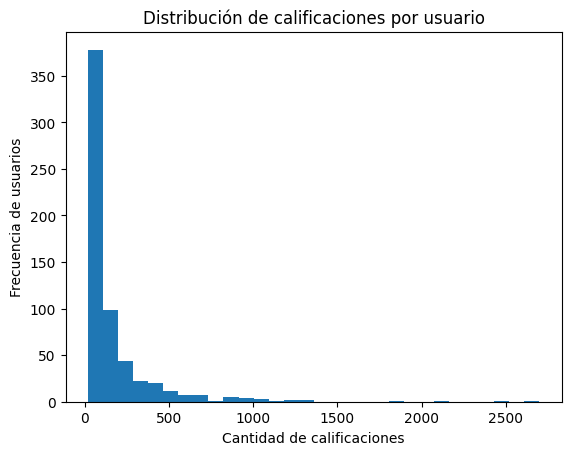

In [19]:
figg2 = plt.hist(user_ratings['cnt_rating'], bins=30)
plt.xlabel('Cantidad de calificaciones')
plt.ylabel('Frecuencia de usuarios')
plt.title('Distribución de calificaciones por usuario')
plt.show()

Mediante el gráfico de barras podemos observar que el pico de calificaciones por usuario en la plataforma está entre 0 y 99. De 100 calificaciones por usuario en adelante vemos una drastica reducción hasta llegar el maximo de un solo usuario con un total de entre 2600 a 2699 peliculas calificadas.

##Distribución de calificaciones por película

In [20]:
cur.execute("""
    SELECT movieId, COUNT(*) as cnt_rating
    FROM ratings
    GROUP BY movieId
""")
movie_ratings = pd.DataFrame(cur.fetchall(), columns=['movieId', 'cnt_rating'])

fig3 = px.histogram(movie_ratings,
                   x='cnt_rating',
                   nbins=30,
                   title='Numero de calificaciones por pelicula',
                   labels={'cnt_rating': 'Cantidad de calificaciones', 'count': 'Numero de peliculas'})

fig3.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig3.show()

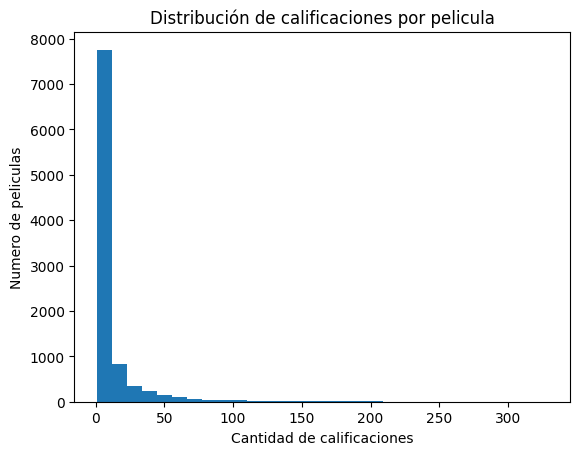

In [21]:
figg3 = plt.hist(movie_ratings['cnt_rating'], bins=30)
plt.xlabel('Cantidad de calificaciones')
plt.ylabel('Numero de peliculas')
plt.title('Distribución de calificaciones por pelicula')
plt.show()

El histograma muestra que la gran mayoria de las peliculas han recibido muy pocas calificaciones, concentrandose principalmente entre 0 y 20. Muy pocas peliculas han sido valoradas por muchos usuarios. Esto puede ser debido a una desigualdad en cuanto a la popularidad de estas

##Distribución de Películas por Año

In [22]:
print("\nDistribución de Películas por Año:\n", df_movies_processed['year'].value_counts().sort_index())
fig4 = px.histogram(df_movies_processed, x='year', title='Distribución de Películas por Año',
                                  labels={'year': 'Año', 'count': 'Número de Películas'})

fig4.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig4.show()


Distribución de Películas por Año:
 year
1903      1
1908      1
1915      1
1916      4
1917      1
       ... 
2014    271
2015    271
2016    211
2017    143
2018     41
Name: count, Length: 104, dtype: int64


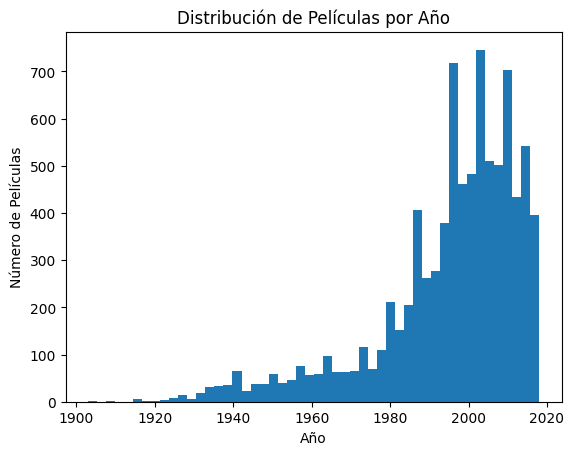

In [23]:
figg4 = plt.hist(df_movies_processed['year'], bins=50)
plt.xlabel('Año')
plt.ylabel('Número de Películas')
plt.title('Distribución de Películas por Año')
plt.show()

La gráfica muestra la evolución de la cantidad de películas producidas por año desde 1903 hasta 2018. En donde se observa que la mayoria de películas fueron publicadas en años recientes entre medidades de la decada del 90 y 2015, año a patir del cual se evidencia un decrecimiento acelerado.

##Distribución de peliculas por década

In [24]:
df_movies_processed['decade'] = (df_movies_processed['year'] // 10 * 10).astype(int)
decade_counts = df_movies_processed['decade'].value_counts().sort_index()
print("\nDistribución de Películas por Década:\n", decade_counts)

fig5 = px.bar(decade_counts, x=decade_counts.index, y=decade_counts.values,
                            title='Distribución de Películas por Década',
                            labels={'index': 'Década', 'y': 'Número de Películas'})
fig5.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig5.show()


Distribución de Películas por Década:
 decade
1900       2
1910       7
1920      30
1930     123
1940     186
1950     230
1960     306
1970     420
1980    1046
1990    1966
2000    2489
2010    1826
Name: count, dtype: int64


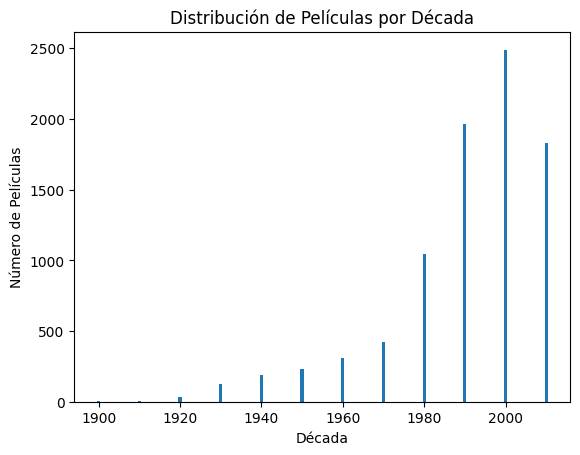

In [25]:
figg5 = plt.bar(decade_counts.index, decade_counts.values)
plt.xlabel('Década')
plt.ylabel('Número de Películas')
plt.title('Distribución de Películas por Década')
plt.show()

Entre las décadas de 1900 y 1920, la producción cinematográfica fue baja y relativamente estable, reflejando los inicios de la industria del cine. A partir de la década de 1970 se observa un crecimiento más marcado, que se intensifica notablemente entre las décadas de 1990 y 2010, alcanzando su punto máximo en la decada del 2000.

##Promedio de clasificaciones por década

In [26]:
#Fusionar los DataFrames de ratings y movies
df_merged_ratings_movies = pd.merge(df_ratings_processed, df_movies_processed[['movieId', 'year']], on='movieId', how='inner')

#Crear la columna 'Decada'
df_merged_ratings_movies['Decada'] = (df_merged_ratings_movies['year'] // 10) * 10
df_merged_ratings_movies['Decada'] = df_merged_ratings_movies['Decada'].astype(int)

avg_ratings_per_decade = df_merged_ratings_movies.groupby('Decada', as_index=False)['rating'].mean().sort_values('Decada')
print("\nPromedio de Calificaciones por Década:\n", avg_ratings_per_decade)

fig6 = px.bar(
    avg_ratings_per_decade,
    x='Decada',
    y='rating',
    labels={'Decada': 'Década', 'rating': 'Promedio de Calificación'},
    title='Promedio de Calificaciones por Década',
    text='rating',
    color='rating',
    color_continuous_scale='Blues',)

fig6.update_traces(texttemplate='%{text:.2f}', textposition='outside')

fig6.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    template='plotly_white')

fig6.show()


Promedio de Calificaciones por Década:
     Decada    rating
0     1900  3.000000
1     1910  3.312500
2     1920  3.721591
3     1930  3.747671
4     1940  3.870665
5     1950  3.831325
6     1960  3.795612
7     1970  3.770983
8     1980  3.488192
9     1990  3.417054
10    2000  3.448094
11    2010  3.489713


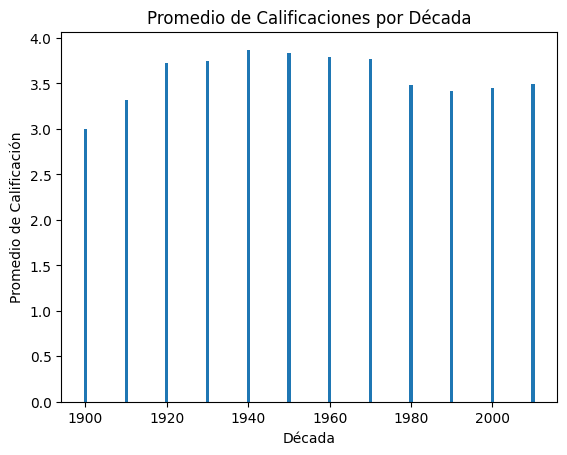

In [27]:
figg6 = plt.bar(avg_ratings_per_decade['Decada'], avg_ratings_per_decade['rating'])
plt.xlabel('Década')
plt.ylabel('Promedio de Calificación')
plt.title('Promedio de Calificaciones por Década')
plt.show()

Se observa que las películas estrenadas en las décadas de 1940 y 1950 obtuvieron los promedios más altos, con calificaciones de 3.87 y 3.85 respectivamente, lo que podría reflejar una época de consolidación artística y narrativa en el cine. A partir de la década de 1960, las calificaciones comienzan a mostrar una leve disminución, destacando un descenso más notorio desde la década 80 en adelante. Las décadas de 1990, 2000 y 2010 presentan los promedios más bajos, con valores cercanos a 3.4, lo cual podría estar relacionado con el aumento en la cantidad de producciones, la diversificación de contenidos o un cambio en los criterios de evaluación por parte del público.

##Frecuencia de Géneros

In [28]:
genres_counts = df_movies_processed.drop(columns=['movieId', 'title', 'year', 'decade'], errors='ignore').sum().sort_values(ascending=False)
print("\nFrecuencia de Géneros:\n", genres_counts)
fig7 = px.bar(genres_counts, x=genres_counts.index, y=genres_counts.values,
                            title='Frecuencia de Géneros', labels={'y': 'Número de Películas', 'index': 'Género'})

fig7.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig7.show()


Frecuencia de Géneros:
 Drama          3696
Comedy         3447
Thriller       1706
Action         1592
Romance        1402
Adventure      1133
Crime          1038
Sci-Fi          887
Horror          874
Fantasy         680
Children        628
Animation       512
Mystery         500
Documentary     405
Musical         325
War             304
Western         159
IMAX            152
Film-Noir        80
dtype: int64


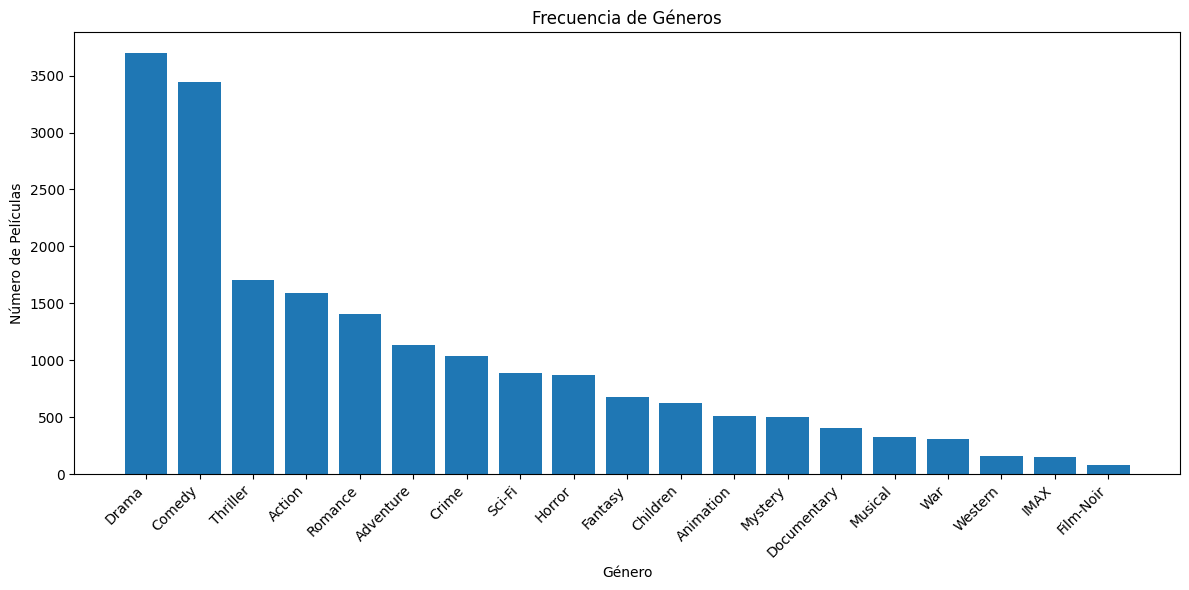

In [29]:
figg7 = plt.figure(figsize=(12, 6)) # Aumentamos el ancho
plt.bar(genres_counts.index, genres_counts.values)
plt.xlabel('Género')
plt.ylabel('Número de Películas')
plt.title('Frecuencia de Géneros')
plt.xticks(rotation=45, ha='right') # Rotamos las etiquetas para mejor legibilidad
plt.tight_layout() # Ajusta el espaciado para que todo quepa
plt.show()

Los generos mas repetidos en las peliculas son los de Drama y Comedy, mientras que los que menos participación tiene son los de Western, IMAX y FIlm-Noir.

##Número de Calificaciones por Usuario (Top 10)

In [30]:
user_ratings_count = df_ratings_processed['userId'].value_counts().sort_values(ascending=False).head(10)
print("\nTop 10 Usuarios con más Calificaciones:\n", user_ratings_count)
fig8 = px.bar(user_ratings_count, x=user_ratings_count.index.astype(str), y=user_ratings_count.values,
                             title='Top 10 Usuarios con más Calificaciones',
                             labels={'y': 'Número de Calificaciones', 'x': 'User ID'})

fig8.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig8.show()


Top 10 Usuarios con más Calificaciones:
 userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
Name: count, dtype: int64


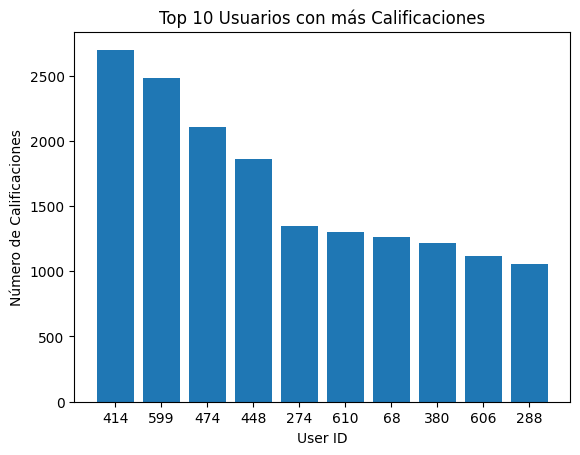

In [31]:
figg8 = plt.bar(user_ratings_count.index.astype(str), user_ratings_count.values)
plt.xlabel('User ID')
plt.ylabel('Número de Calificaciones')
plt.title('Top 10 Usuarios con más Calificaciones')
plt.show()

El top 10 de usuarios con más calificaciónes superan las 1000 calificaciones cada uno, y el usuarios que mas calificaciones ha realizada cuenta con 2698.

##Número de Calificaciones por Película (Top 10)

In [32]:
n_top_movies = 10
print(f"\nTop {n_top_movies} Películas con Más Calificaciones (usando función):\n")
df_top_n_movies = top_n_peliculas_valoradas(cur)
print(df_top_n_movies)
fig9 = px.bar(df_top_n_movies, x='title', y='total_valoraciones',
                          title=f'Top {n_top_movies} Películas con Más Calificaciones',
                          labels={'title': 'Título de la Película', 'total_valoraciones': 'Número de Valoraciones'})

fig9.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig9.show()


Top 10 Películas con Más Calificaciones (usando función):

                                title  total_valoraciones  movieId
0                        Forrest Gump                 329      356
1           Shawshank Redemption, The                 317      318
2                        Pulp Fiction                 307      296
3           Silence of the Lambs, The                 279      593
4                         Matrix, The                 278     2571
5  Star Wars: Episode IV - A New Hope                 251      260
6                       Jurassic Park                 238      480
7                          Braveheart                 237      110
8          Terminator 2: Judgment Day                 224      589
9                    Schindler's List                 220      527


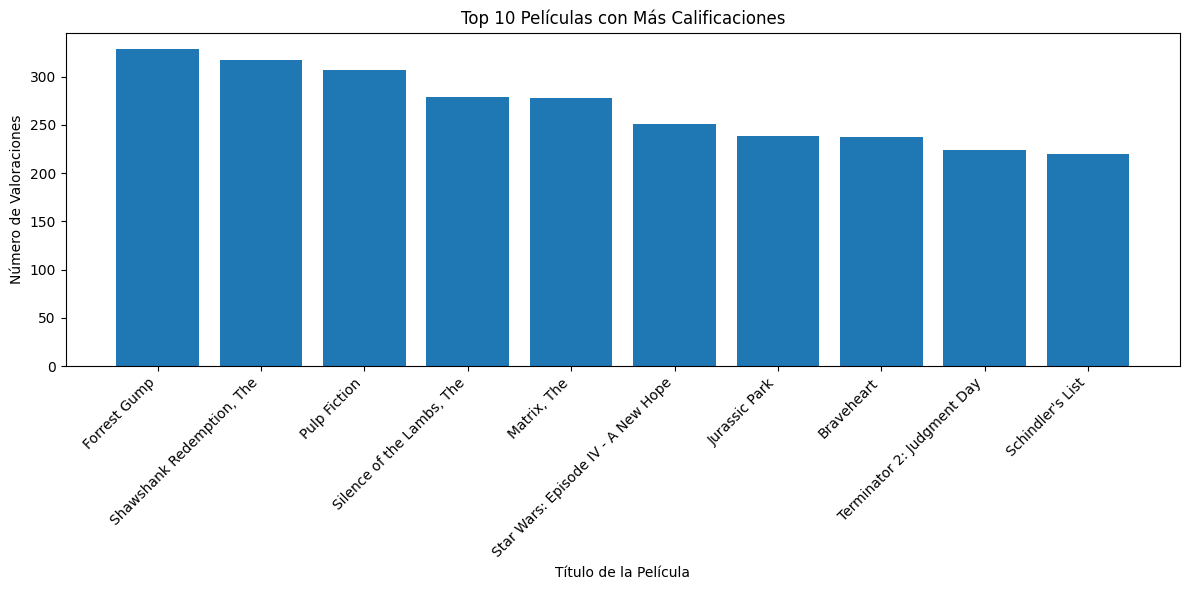

In [33]:
figg9 = plt.figure(figsize=(12, 6))
plt.bar(df_top_n_movies['title'], df_top_n_movies['total_valoraciones'])
plt.xlabel('Título de la Película')
plt.ylabel('Número de Valoraciones')
plt.title(f'Top {n_top_movies} Películas con Más Calificaciones')
plt.xticks(rotation=45, ha='right') # Rotamos las etiquetas para mejor legibilidad
plt.tight_layout() # Ajusta el espaciado para que todo quepa
plt.show()

Forest Grump es la pelicula con mas calificaciones del catalogo con un total de 329, mientras que al final del top 10, con 109 calificaciones por detras, se encuenta Shindler´s List con 220 calificaciones.

##Top películas segun calificación

In [36]:
df_rating = consultar_rating_con_titulo1(con, rating=2)
rating=2

In [37]:
# Mostrar conteo por película
conteo = df_rating['title'].value_counts().reset_index()
conteo.columns = ['Título de la película', f'Cantidad de calificaciones = {rating}']

print(f"\nTop películas con calificación = {rating}:")
display(conteo.head(20))


Top películas con calificación = 2:


,Título de la película,Cantidad de calificaciones = 2
0,Ace Ventura: Pet Detective,27
1,Ace Ventura: When Nature Calls,25
2,Batman Forever,22
3,"Nutty Professor, The",22
4,Star Wars: Episode I - The Phantom Menace,20
5,Waterworld,19
6,True Lies,17
7,Batman & Robin,16
8,Home Alone,15
9,Jurassic Park,15


In [38]:
top_conteo = conteo.head(10)
fig10 = px.bar(top_conteo,
              y='Título de la película',
              x=f'Cantidad de calificaciones = {rating}',
              orientation='h',
              title=f"Top 10 películas con calificación {rating}",
              labels={'Título de la película': 'Título de la Película',
                      f'Cantidad de calificaciones = {rating}': 'Cantidad de Calificaciones'},
              color=f'Cantidad de calificaciones = {rating}',
              color_continuous_scale='Greens')
fig10.update_layout(yaxis={'categoryorder':'total ascending'})
fig10.show()

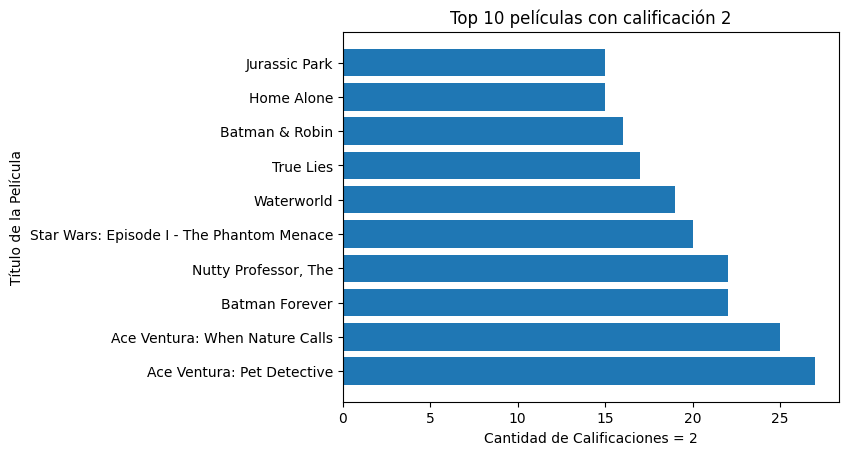

In [39]:
top_conteo = conteo.head(10)
figg10 = plt.barh(top_conteo['Título de la película'], top_conteo[f'Cantidad de calificaciones = {rating}'])
plt.xlabel(f'Cantidad de Calificaciones = {rating}')
plt.ylabel('Título de la Película')
plt.title(f'Top 10 películas con calificación {rating}')
plt.show()

#Generación de bases filtradas
---

Guardar los DataFrame como una tabla SQL

In [41]:
# Crear DataFrame con películas que tienen género y más de 10 calificaciones, incluyendo las calificaciones (peliculas con rating entre 4 y 5)
df_peliculas_filtradas = pd.read_sql("""
    SELECT m.movieId, m.title, m.year,
           m."Action", m."Adventure", m."Animation", m."Children", m."Comedy", m."Crime",
           m."Film-Noir", m."Horror", m."IMAX", m."Musical", m."Mystery", m."Romance",
           m."Sci-Fi", m."Thriller", m."War", m."Western",
           AVG(r.rating) AS avg_rating,
           COUNT(r.rating) AS num_ratings
    FROM movies_clean m
    JOIN ratings r ON m.movieId = r.movieId
    WHERE m."(no genres listed)" = 0
      AND r.rating BETWEEN 4 AND 5
    GROUP BY m.movieId, m.title, m.year
    HAVING COUNT(r.rating) > 10
""", con)

df_peliculas_filtradas

DatabaseError: Execution failed on sql '
    SELECT m.movieId, m.title, m.year,
           m."Action", m."Adventure", m."Animation", m."Children", m."Comedy", m."Crime",
           m."Film-Noir", m."Horror", m."IMAX", m."Musical", m."Mystery", m."Romance",
           m."Sci-Fi", m."Thriller", m."War", m."Western",
           AVG(r.rating) AS avg_rating,
           COUNT(r.rating) AS num_ratings
    FROM movies_clean m
    JOIN ratings r ON m.movieId = r.movieId
    WHERE m."(no genres listed)" = 0
      AND r.rating BETWEEN 4 AND 5
    GROUP BY m.movieId, m.title, m.year
    HAVING COUNT(r.rating) > 10
': no such table: movies_clean

In [40]:
df_peliculas_filtradas.to_sql('full_ratings', con, if_exists='replace', index=False)
movies_con_generos.to_sql('movies_clean', con, if_exists='replace', index=False)

NameError: name 'df_peliculas_filtradas' is not defined

---
---

## Exploración profunda: Tabla ratings



In [ ]:
try:
    # 1. Conteo de usuarios únicos
    cur.execute("SELECT COUNT(DISTINCT userId) FROM ratings;")
    num_usuarios_unicos = cur.fetchone()[0]
    print(f"Número de usuarios únicos: {num_usuarios_unicos}")

    # 2. Medidas estadísticas
    cur.execute("SELECT AVG(rating), MIN(rating), MAX(rating) FROM ratings;")
    promedio_rating, min_rating, max_rating = cur.fetchone()
    print(f"Promedio de rating: {promedio_rating:.2f}")
    print(f"Rating mínimo: {min_rating}")
    print(f"Rating máximo: {max_rating}")

    # 3. Moda
    cur.execute("SELECT rating FROM ratings;")
    ratings = [row[0] for row in cur.fetchall()]
    if ratings:
        moda_rating = calcular_moda(ratings)
        print(f"Moda del rating: {moda_rating}")
    else:
        print("No hay ratings para calcular la moda.")

except sql.Error as e:
    print(f"Error al explorar la tabla 'ratings': {e}")

Número de usuarios únicos: 610
Promedio de rating: 3.50
Rating mínimo: 0.5
Rating máximo: 5.0
Moda del rating: 4.0


## Exploración profunda: Tabla movies

Para esta exploración se usara la librería de pandas ya que permite una manipulación mas rápida y menos engorrosa de la tabla al realizar los split's y extracciones de fragmentos de la cadena de texto mas rápidamente

In [ ]:
#Separación en columnas de los generos

movies=pd.read_sql('select * from movies', con)
genres=movies['genres'].str.split('|')
te = TransactionEncoder()
genres = te.fit(genres).transform(genres)
genres =pd.DataFrame(genres, columns=te.columns_)
len(movies['genres'].unique())
genres

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8626,True,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
8627,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
8628,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
8629,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
movies_con_generos = pd.concat([movies, genres], axis=1)
movies_con_generos = movies_con_generos.drop(columns='genres')
movies_con_generos = movies_con_generos.astype({col: int for col in movies_con_generos.columns if movies_con_generos[col].dtype == 'bool'})
movies_con_generos.head()

,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 1. Extraer el año (4 dígitos) de cualquier paréntesis
year = movies_con_generos['title'].str.extract(r'\((\d{4})\)')[0]

# Convertir a entero nullable
movies_con_generos['year'] = year.astype('Int64')

# 2. Quitar cualquier "(YYYY)" del título
movies_con_generos['title'] = (
    movies_con_generos['title']
        .str.replace(r'\s*\(\d{4}\)', '', regex=True)
        .str.strip()
)

In [ ]:
generos = [col for col in movies_con_generos.columns if col not in ['movieId', 'title', 'year']]
movies_con_generos = movies_con_generos[['movieId', 'title', 'year'] + generos]

In [ ]:
movies_con_generos

,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,<NA>,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,<NA>,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,<NA>,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,<NA>,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,<NA>,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8626,193581,Black Butler: Book of the Atlantic,<NA>,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8627,193583,No Game No Life: Zero,<NA>,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8628,193585,Flint,<NA>,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8629,193587,Bungo Stray Dogs: Dead Apple,<NA>,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Guardar el DataFrame como una tabla SQL llamada 'movies_clean'
movies_con_generos.to_sql('movies_clean', con, if_exists='replace', index=False)
pd.read_sql("SELECT * FROM movies_clean LIMIT 5", con)

,movieId,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,None,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,None,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,None,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,None,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,None,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# contar las películas sin género
conteo = pd.read_sql("""
    SELECT COUNT(*) AS sin_genero
    FROM movies_clean
    WHERE "(no genres listed)" = 1
""", con)

conteo

,sin_genero
0,0


In [ ]:
# # contar las películas sin género (otra forma)
# pd.read_sql("""WITH t1 AS (SELECT "(no genres listed)", COUNT(*) AS cnt
#         FROM movies_clean
#         WHERE "(no genres listed)" = 1
#         GROUP BY "(no genres listed)")
#         SELECT cnt AS sin_genero FROM t1""", con)

In [ ]:
# obtener los detalles de las películas sin género
pd.read_sql("""
    SELECT movieId, title, year
    FROM movies_clean
    WHERE "(no genres listed)" = 1
    ORDER BY year, title
""", con)

,movieId,title,year


In [ ]:
# obtener los detalles de las películas sin año
pd.read_sql("""
    SELECT movieId, title, year
    FROM movies_clean
    WHERE year IS NULL
    ORDER BY title
""", con)

,movieId,title,year
0,117867,'71,None
1,97757,'Hellboy': The Seeds of Creation,None
2,26564,'Round Midnight,None
3,27751,'Salem's Lot,None
4,779,'Til There Was You,None
...,...,...,...
8626,193567,anohana: The Flower We Saw That Day - The Movie,None
8627,2600,eXistenZ,None
8628,5507,xXx,None
8629,33158,xXx: State of the Union,None


In [ ]:
# contar películas por año
tabla_conteo = pd.read_sql("""
    SELECT year AS Año, COUNT(*) AS "Cantidad de películas"
    FROM movies_clean
    WHERE year IS NOT NULL
    GROUP BY year
    ORDER BY year
""", con)

In [ ]:
# graficar conteo de películas por año
fig = px.bar(tabla_conteo,
             x='Año',
             y='Cantidad de películas',
             title='Cantidad de películas por año',
             labels={'Año': 'Año', 'Cantidad de películas': 'Número de películas'})

# Personalizar las etiquetas del eje x para mostrar solo cada 5 años
years = tabla_conteo['Año'].tolist()
if years:
    tickvals = years[::5]
    ticktext = [str(year) for year in years[::5]]
    fig.update_layout(xaxis=dict(tickmode='array',
                                 tickvals=tickvals,
                                 ticktext=ticktext,
                                 tickangle=90))

fig.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig.show()

La gráfica muestra la evolución de la cantidad de películas producidas por año desde 1902 hasta 2018. Entre las décadas de 1900 y 1920, la producción cinematográfica fue baja y relativamente estable, reflejando los inicios de la industria del cine. A partir de la década de 1970 se observa un crecimiento más marcado, que se intensifica notablemente entre las décadas de 1990 y 2010, alcanzando su punto máximo alrededor del año 2002 con más de 300 películas anuales.

In [ ]:
# Distribución por década
conteo_decadas = pd.read_sql("""
    SELECT
        (year / 10) * 10 AS decada,
        COUNT(*) AS cantidad
    FROM movies_clean
    WHERE year IS NOT NULL
    GROUP BY decada
    ORDER BY decada
""", con)

conteo_decadas

,decada,cantidad


In [ ]:
# Cantidad de películas por género
conteo_generos = pd.read_sql("""
    SELECT
        SUM("Action") AS Action,
        SUM("Adventure") AS Adventure,
        SUM("Animation") AS Animation,
        SUM("Children") AS Children,
        SUM("Comedy") AS Comedy,
        SUM("Crime") AS Crime,
        SUM("Documentary") AS Documentary,
        SUM("Drama") AS Drama,
        SUM("Fantasy") AS Fantasy,
        SUM("Film-Noir") AS "Film-Noir",
        SUM("Horror") AS Horror,
        SUM("IMAX") AS IMAX,
        SUM("Musical") AS Musical,
        SUM("Mystery") AS Mystery,
        SUM("Romance") AS Romance,
        SUM("Sci-Fi") AS "Sci-Fi",
        SUM("Thriller") AS Thriller,
        SUM("War") AS War,
        SUM("Western") AS Western
    FROM movies_clean
""", con)

conteo_generos.T.sort_values(by=0, ascending=False).rename(columns={0: 'cantidad'})

,cantidad
Drama,3696
Comedy,3447
Thriller,1706
Action,1592
Romance,1402
Adventure,1133
Crime,1038
Sci-Fi,887
Horror,874
Fantasy,680


In [ ]:
# Transformar el DataFrame para graficar
conteo_generos_df = conteo_generos.T.sort_values(by=0, ascending=False).rename(columns={0: 'cantidad'})
conteo_generos_df = conteo_generos_df.reset_index().rename(columns={'index': 'género'})

# Crear gráfica
fig1 = px.bar(conteo_generos_df,
             x='género',
             y='cantidad',
             title='Cantidad de películas por género',
             labels={'género': 'Género', 'cantidad': 'Número de películas'},
             text='cantidad')

fig1.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig1.update_layout(xaxis_tickangle=45)
fig1.show()

In [ ]:
# Películas con múltiples géneros
conteo_generos_por_pelicula = pd.read_sql("""
    SELECT
        movieId,
        title,
        year,
        (
            "Action" + "Adventure" + "Animation" + "Children" +
            "Comedy" + "Crime" + "Documentary" + "Drama" +
            "Fantasy" + "Film-Noir" + "Horror" + "IMAX" +
            "Musical" + "Mystery" + "Romance" + "Sci-Fi" +
            "Thriller" + "War" + "Western"
        ) AS n_genres
    FROM movies_clean
""", con)

conteo_generos_por_pelicula.head()

,movieId,title,year,n_genres
0,1,Toy Story,None,5
1,2,Jumanji,None,3
2,3,Grumpier Old Men,None,2
3,4,Waiting to Exhale,None,3
4,5,Father of the Bride Part II,None,1


# PANDAS

In [ ]:
#Crear df's de pandas con las tablas
df_ratings = pd.read_sql('select * from ratings', con)
df_movies = pd.read_sql('select * from movies', con)

## Exploración de df_ratings

In [ ]:
#Visualización de df_ratings
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
#Renombrar columnas del df e indexarlo con movie_id
df_ratings.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
df_ratings = df_ratings.set_index('movie_id')
df_ratings

,user_id,rating,timestamp
movie_id,,,
1,1,4.0,964982703
3,1,4.0,964981247
6,1,4.0,964982224
47,1,5.0,964983815
50,1,5.0,964982931
...,...,...,...
166534,610,4.0,1493848402
168248,610,5.0,1493850091
168250,610,5.0,1494273047


In [ ]:
#La columna 'fecha_vista' es en realidad un unix timestamp, es decir, el número de segundos desde el 1 de enero de 1970 (UTC). Se restructura.
df_ratings['fecha_vista'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings

,user_id,rating,timestamp,fecha_vista
movie_id,,,,
1,1,4.0,964982703,2000-07-30 18:45:03
3,1,4.0,964981247,2000-07-30 18:20:47
6,1,4.0,964982224,2000-07-30 18:37:04
47,1,5.0,964983815,2000-07-30 19:03:35
50,1,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...
166534,610,4.0,1493848402,2017-05-03 21:53:22
168248,610,5.0,1493850091,2017-05-03 22:21:31
168250,610,5.0,1494273047,2017-05-08 19:50:47


## Exploración de df_movies

In [ ]:
#Visualización de df_movies
df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [ ]:
#Renombrar columnas del df e indexarlo por movie_id
df_movies.columns = ['movie_id', 'titulo', 'genero']
df_movies = df_movies.set_index('movie_id')
df_movies

ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements

# Exploracion de insights

A continuacion se realizara una serie de consultas SQL con el fin de extraer insights clave del dataset de movies y ratings. Se busca conocer el comportamiento de los usuarios, identificar patrones de calificacion y preparar el entendimiento del negocio antes del modelado

In [ ]:
#Crear df's de pandas con las tablas
df_ratings = pd.read_sql('select * from ratings', con)
df_movies = pd.read_sql('select * from movies', con)

In [ ]:
# 1. Cantidad total de peliculas y usuarios unicos
cur.execute("SELECT COUNT(DISTINCT movieId), COUNT(DISTINCT userId) FROM ratings;")
total_peliculas, total_usuarios = cur.fetchone()
print(f"Total de peliculas: {total_peliculas}")
print(f"Total de usuarios: {total_usuarios}")

Total de peliculas: 9724
Total de usuarios: 610


In [ ]:
# 2. Top 10 peliculas con mas valoraciones
cur.execute("""
    SELECT r.movieId, m.title, COUNT(*) AS total_valoraciones
    FROM ratings r
    JOIN movies m ON r.movieId = m.movieId
    GROUP BY r.movieId, m.title
    ORDER BY total_valoraciones DESC
    LIMIT 10;
""")
top_movies = cur.fetchall()
print("\nTop 10 peliculas con mas valoraciones:")
for movie in top_movies:
    print(f"{movie[1]} - {movie[2]} valoraciones")


Top 10 peliculas con mas valoraciones:
Forrest Gump - 329 valoraciones
Shawshank Redemption, The - 317 valoraciones
Pulp Fiction - 307 valoraciones
Silence of the Lambs, The - 279 valoraciones
Matrix, The - 278 valoraciones
Star Wars: Episode IV - A New Hope - 251 valoraciones
Jurassic Park - 238 valoraciones
Braveheart - 237 valoraciones
Terminator 2: Judgment Day - 224 valoraciones
Schindler's List - 220 valoraciones


- Las 10 peliculas con mas valoraciones en el dataset son de los años 1990 a 1999

In [ ]:
# 3. Distribucion de calificaciones
cur.execute("""
    SELECT rating, COUNT(*) as conteo
    FROM ratings
    GROUP BY rating
    ORDER BY rating
""")

bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5.0]
#plt.hist(df_ratings['rating'], bins=bins, edgecolor='black', color='skyblue')
#plt.xticks(bins)
#plt.title('Distribucion de calificaciones')
#plt.xlabel('Calificacion')
#plt.ylabel('Frecuencia')
#plt.show()

fig2 = px.histogram(df_ratings,
                   x='rating',
                   title='Distribucion de calificaciones',
                   labels={'rating': 'Calificacion', 'count': 'Frecuencia'},
                   histnorm='', # No aplicar normalización por defecto
                   range_x=[min(bins), max(bins)], # Establecer el rango del eje x
                   nbins=len(bins) - 1, # Definir el número de bins
                   category_orders={'rating': [str(b) for b in bins[:-1]]}) # Asegurar el orden de las etiquetas

# Personalizar el fondo y eliminar las líneas de los ejes
fig2.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig2.update_traces(marker=dict(line=dict(width=1, color='black')),
                  marker_color='skyblue')

fig2.update_layout(xaxis=dict(tickvals=bins))

fig2.show()

 El histograma muestra que la mayoria de las calificaciones se concentran entre 3.0 y 4.0 con un pico en la calificaicón 4.0, lo cual indica una tendencia positiva en la percepcion de las peliculas por parte de los usuarios. Las calificaciones bajas, entre 0 a 2.5, son menos frecuentes, lo que nos podria decir que los usuarios tienden a valorar mas positivamente las peliculas.

In [ ]:
# 4. Numero de calficaciones por usuario
cur.execute("""
    SELECT userId, COUNT(*) as cnt_rating
    FROM ratings
    GROUP BY userId
""")
user_ratings = pd.DataFrame(cur.fetchall(), columns=['userId', 'cnt_rating'])

#plt.hist(user_ratings['cnt_rating'], bins=30, color='lightcoral', edgecolor='black')
#plt.title('Numero de calificaciones por usuario')
#plt.xlabel('Cantidad de calificaciones')
#plt.ylabel('Frecuencia de usuarios')
#plt.show()

fig3 = px.histogram(user_ratings,
                   x='cnt_rating',
                   nbins=30,
                   title='Numero de calificaciones por usuario',
                   labels={'cnt_rating': 'Cantidad de calificaciones', 'count': 'Frecuencia de usuarios'})

fig3.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

fig3.show()

Mediante el gráfico de barras podemos observar que el pico de calificaciones por usuario en la plataforma está entre 0 y 99. De 100 calificaciones por usuario en adelante vemos una drastica reducción hasta llegar el maximo de un solo usuario con un total de entre 2600 a 2699 peliculas calificadas.


In [ ]:
# Crear un DataFrame con usuarios que tienen entre 30 y 500 calificaciones
usuarios_filtrados = pd.read_sql('''
    SELECT "userId" AS usuario,
           COUNT(*) AS cnt_rat
    FROM ratings
    GROUP BY "userId"
    HAVING cnt_rat BETWEEN 30 AND 500
    ORDER BY cnt_rat ASC
''', con)

#plt.figure(figsize=(8, 6))
#plt.hist(usuarios_filtrados['cnt_rat'], bins=30, color='teal', edgecolor='black')
#plt.title('Distribución de usuarios con 30 a 500 calificaciones')
#plt.xlabel('Cantidad de calificaciones')
#plt.ylabel('Frecuencia')
#plt.grid(True)
#plt.show()

fig4 = px.histogram(usuarios_filtrados,
                   x='cnt_rat',
                   nbins=15,
                   title='Distribución de usuarios con 30 a 500 calificaciones',
                   labels={'cnt_rat': 'Cantidad de calificaciones', 'count': 'Frecuencia de usuarios'})

fig4.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

fig4.show()

El grafico muestra que dentro del rango filtrado de usuarios que realizaron entre 30 y 500 calificaciones, la mayoria esta en el segmento inferior, con un pico entre los 50 y 99 registros aproximadamente. A medida que aumenta la cantidad de calificaciones por usuario, la frecuencia disminuye considerablemente, lo que evidencia que aunque hay usuarios activos la gran mayoria tiene una participación moderada a la hora de valorar las peliculas.

In [ ]:
# 6. Numero de calificaciones por pelicula
cur.execute("""
    SELECT movieId, COUNT(*) as cnt_rating
    FROM ratings
    GROUP BY movieId
""")
movie_ratings = pd.DataFrame(cur.fetchall(), columns=['movieId', 'cnt_rating'])

#plt.hist(movie_ratings['cnt_rating'], bins=30, color='orange', edgecolor='black')
#plt.title('Numero de calificaciones por pelicula')
#plt.xlabel('Cantidad de calificaciones')
#plt.ylabel('Numero de peliculas')
#plt.show()

fig5 = px.histogram(movie_ratings,
                   x='cnt_rating',
                   nbins=30,
                   title='Numero de calificaciones por pelicula',
                   labels={'cnt_rating': 'Cantidad de calificaciones', 'count': 'Numero de peliculas'})

fig5.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False))

fig5.show()

El histograma muestra que la gran mayoria de las peliculas han recibido muy pocas calificaciones, concentrandose principalmente entre 0 y 20. Muy pocas peliculas han sido valoradas por muchos usuarios. Esto puede ser debido a una desigualdad en cuanto a la popularidad de estas

In [ ]:
# películas con entre 20 y 120 calificaciones
query = """
    SELECT movieId, COUNT(*) AS cnt_rating
    FROM ratings
    GROUP BY movieId
    HAVING cnt_rating BETWEEN 20 AND 120
"""
movie_ratings_filtrado = pd.read_sql(query, con)

In [ ]:
fig6 = px.histogram(movie_ratings_filtrado,
                   x='cnt_rating',
                   nbins=20,
                   title='Número de calificaciones por película (entre 20 y 120)',
                   labels={'cnt_rating': 'Cantidad de calificaciones', 'count': 'Número de películas'})

fig6.update_layout(
    plot_bgcolor='white',
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False)
)

fig6.show()

##Promedio de clasficiaciones por década

In [ ]:
#Fusionar los DataFrames de ratings y movies
df_merged_ratings_movies = pd.merge(df_ratings_processed, df_movies_processed[['movieId', 'year']], on='movieId', how='inner')

#Crear la columna 'Decada'
df_merged_ratings_movies['Decada'] = (df_merged_ratings_movies['year'] // 10) * 10
df_merged_ratings_movies['Decada'] = df_merged_ratings_movies['Decada'].astype(int)

avg_ratings_per_decade = df_merged_ratings_movies.groupby('Decada', as_index=False)['rating'].mean().sort_values('Decada')
print("\nPromedio de Calificaciones por Década:\n", avg_ratings_per_decade)

fig_avg_ratings_decade = px.bar(
    avg_ratings_per_decade,
    x='Decada',
    y='rating',
    labels={'Decada': 'Década', 'rating': 'Promedio de Calificación'},
    title='Promedio de Calificaciones por Década',
    text='rating',
    color='rating',
    color_continuous_scale='Blues',)

fig_avg_ratings_decade.update_traces(texttemplate='%{text:.2f}', textposition='outside')

fig_avg_ratings_decade.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    template='plotly_white')

fig_avg_ratings_decade.show()


Promedio de Calificaciones por Década:
     Decada    rating
0     1900  3.000000
1     1910  3.312500
2     1920  3.721591
3     1930  3.747671
4     1940  3.870665
5     1950  3.831325
6     1960  3.795612
7     1970  3.770983
8     1980  3.488192
9     1990  3.417054
10    2000  3.448094
11    2010  3.489713


Se observa que las películas estrenadas en las décadas de 1940 y 1950 obtuvieron los promedios más altos, con calificaciones de 3.87 y 3.85 respectivamente, lo que podría reflejar una época de consolidación artística y narrativa en el cine. A partir de la década de 1960, las calificaciones comienzan a mostrar una leve disminución, destacando un descenso más notorio desde la década 80 en adelante. Las décadas de 1990, 2000 y 2010 presentan los promedios más bajos, con valores cercanos a 3.4, lo cual podría estar relacionado con el aumento en la cantidad de producciones, la diversificación de contenidos o un cambio en los criterios de evaluación por parte del público.

In [ ]:
def consultar_rating_con_titulo(con, rating=5, graficar=False):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Consulta SQL para traer ratings del valor dado y títulos de películas
    query = f"""
        SELECT r.movieId, m.title, r.rating
        FROM ratings r
        JOIN movies m ON r.movieId = m.movieId
        WHERE r.rating = {rating}
    """
    df_rating = pd.read_sql(query, con)

    # Verificar si se encontraron resultados
    if df_rating.empty:
        print(f"No se encontraron películas con calificación {rating}.")
        return

    # Mostrar conteo por película
    conteo = df_rating['title'].value_counts().reset_index()
    conteo.columns = ['Título de la película', f'Cantidad de calificaciones = {rating}']

    print(f"\nTop películas con calificación = {rating}:")
    display(conteo.head(20))

    # Graficar
    if graficar:
        plt.figure(figsize=(10, 5))
        conteo.head(10).plot(kind='barh', x='Título de la película',
                             y=f'Cantidad de calificaciones = {rating}',
                             color='mediumseagreen', edgecolor='black', legend=False)
        plt.title(f"Top 10 películas con calificación {rating}")
        plt.xlabel('Cantidad de calificaciones')
        plt.ylabel('Título de la película')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


Top películas con calificación = 2:


,Título de la película,Cantidad de calificaciones = 2
0,Ace Ventura: Pet Detective,27
1,Ace Ventura: When Nature Calls,25
2,Batman Forever,22
3,"Nutty Professor, The",22
4,Star Wars: Episode I - The Phantom Menace,20
5,Waterworld,19
6,True Lies,17
7,Batman & Robin,16
8,Home Alone,15
9,Jurassic Park,15


<Figure size 1000x500 with 0 Axes>

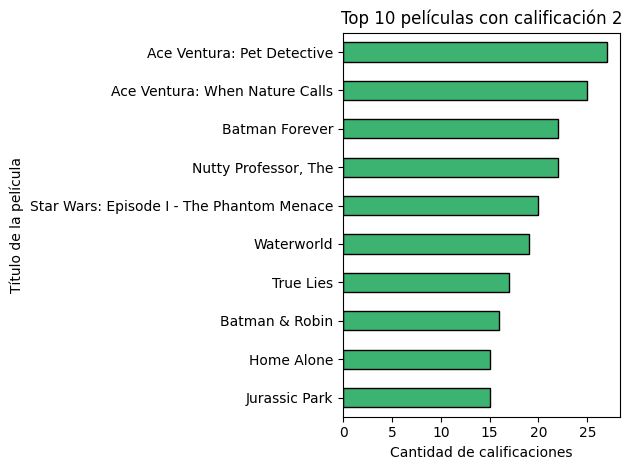

In [ ]:
consultar_rating_con_titulo(con, rating=2, graficar=True)

In [ ]:
# Crear DataFrame con películas que tienen género y más de 10 calificaciones, incluyendo las calificaciones (peliculas con rating entre 4 y 5)
df_peliculas_filtradas = pd.read_sql("""
    SELECT m.movieId, m.title, m.year,
           m."Action", m."Adventure", m."Animation", m."Children", m."Comedy", m."Crime",
           m."Film-Noir", m."Horror", m."IMAX", m."Musical", m."Mystery", m."Romance",
           m."Sci-Fi", m."Thriller", m."War", m."Western",
           AVG(r.rating) AS avg_rating,
           COUNT(r.rating) AS num_ratings
    FROM movies_clean m
    JOIN ratings r ON m.movieId = r.movieId
    WHERE m."(no genres listed)" = 0
      AND r.rating BETWEEN 4 AND 5
    GROUP BY m.movieId, m.title, m.year
    HAVING COUNT(r.rating) > 10
""", con)

df_peliculas_filtradas

In [ ]:
# Guardar el DataFrame como una tabla SQL
df_peliculas_filtradas.to_sql('full_ratings', con, if_exists='replace', index=False)

In [ ]:
movies_con_generos.to_sql('movies_clean', con, if_exists='replace', index=False)